In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import tensordot
from tensorflow import keras
from tensorflow.keras import layers
import os


In [443]:
books_data_path = "data/Books.csv"
ratings_data_path = "data/Ratings.csv"
users_data_path = "data/Users.csv"

books_df = pd.read_csv(books_data_path)
ratings_df = pd.read_csv(ratings_data_path)
users_df = pd.read_csv(users_data_path)

# Drop unnecessary columns from the books DataFrame
#columns_to_drop = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L']
#books_df.drop(labels=columns_to_drop, axis=1, inplace=True)


/var/folders/1d/7ynr__411fx9qj9r1bgh72cc0000gn/T/ipykernel_7568/48023150.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv(books_data_path)


In [444]:
# Identify and drop rows with problematic 'Year-Of-Publication' values
invalid_publication_years = (books_df['Year-Of-Publication'] == 'DK Publishing Inc') | (books_df['Year-Of-Publication'] == 'Gallimard')
books_df = books_df.drop(books_df[invalid_publication_years].index)

# Verify that rows with invalid 'Year-Of-Publication' values are dropped
print(books_df[invalid_publication_years])

# Convert 'Year-Of-Publication' to integer type
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype(int)

# Print data types of the DataFrame
print(books_df.dtypes)

Empty DataFrame
Columns: [ISBN, Book-Title, Book-Author, Year-Of-Publication, Publisher, Image-URL-S, Image-URL-M, Image-URL-L]
Index: []
ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


/var/folders/1d/7ynr__411fx9qj9r1bgh72cc0000gn/T/ipykernel_7568/1378467526.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(books_df[invalid_publication_years])


In [445]:
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [446]:
ratings_df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [447]:
# Select the first 20000 rows from the ratings DataFrame
final_ratings_df = ratings_df[:20000]

# Merge ratings and books DataFrames based on 'ISBN' using a left join
merged_books_ratings = pd.merge(ratings_df, books_df, on='ISBN', how='left')

# Group by 'ISBN' and calculate the sum of each column


dropped_books = merged_books_ratings.dropna()

cleaned_books = dropped_books.sort_values('ISBN', ascending=True)

collaborative_books = cleaned_books.drop_duplicates('ISBN')






In [448]:
collaborative_books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
703628,171118,0000913154,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...
357256,86123,0001010565,0,Mog's Christmas,Judith Kerr,1992.0,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...
103677,23902,0001046438,9,Liar,Stephen Fry,0.0,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...
807953,196149,0001046713,0,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...
103678,23902,000104687X,6,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993.0,HarperCollins Publishers,http://images.amazon.com/images/P/000104687X.0...,http://images.amazon.com/images/P/000104687X.0...,http://images.amazon.com/images/P/000104687X.0...
...,...,...,...,...,...,...,...,...,...,...
1100731,264317,B000234N76,0,Falling Angels,Tracy Chevalier,2001.0,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...
423108,100906,B000234NC6,0,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002.0,Knopf,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...
419279,100088,B00029DGGO,0,"Good Wife Strikes Back, The",Elizabeth Buchan,0.0,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...
743545,179791,B0002JV9PY,0,The Blockade Runners,Jules Verne,0.0,Digireads.com,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...


In [449]:
books_df[books_df['ISBN'] == '034545104X']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2966,034545104X,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [450]:
final_ratings_df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
19995,3757,843222264X,7
19996,3757,8432222658,7
19997,3757,8432222666,7
19998,3757,8432222674,7


In [451]:


# Convert relevant columns to lists
isbn_list = collaborative_books['ISBN'].tolist()
title_list = collaborative_books['Book-Title'].tolist()
author_list = collaborative_books['Book-Author'].tolist()
year_list = collaborative_books['Year-Of-Publication'].tolist()
publisher_list = collaborative_books['Publisher'].tolist()
image_list = collaborative_books['Image-URL-M'].tolist()

# Print the length of each list
print(f"Total ISBNs: {len(isbn_list)}")
print(f"Total Titles: {len(title_list)}")
print(f"Total Authors: {len(author_list)}")
print(f"Total Publication Years: {len(year_list)}")
print(f"Total Publishers: {len(publisher_list)}")


# Create a new DataFrame with different variable names
new_books_df = pd.DataFrame({
    'Unique_ISBN': isbn_list,
    'Unique_Title': title_list,
    'Unique_Author': author_list,
    'Publication_Year_Unique': year_list,
    'Unique_Publisher': publisher_list, 
    'Image': image_list
})

# Select the first 20000 rows of the new DataFrame
new_books_df = new_books_df[:20000]

Total ISBNs: 270144
Total Titles: 270144
Total Authors: 270144
Total Publication Years: 270144
Total Publishers: 270144


In [452]:
new_books_df[new_books_df['Unique_ISBN'] == '0340565276']

,Unique_ISBN,Unique_Title,Unique_Author,Publication_Year_Unique,Unique_Publisher,Image


In [453]:
final_ratings_df = merged_books_ratings.sample(n=20000, random_state=42)

# Extract unique User-IDs from the final_ratings_df DataFrame and convert to a list
unique_user_ids = final_ratings_df['User-ID'].unique().tolist()

# Perform User-ID encoding
encoded_user = {user_id: index for index, user_id in enumerate(unique_user_ids)}

# Reverse the encoding process to map encoded numbers back to User-IDs
user_encoded_to_user = {index: user_id for index, user_id in enumerate(unique_user_ids)}



In [454]:
# Extract unique ISBNs from the final_ratings_df DataFrame and convert to a list
unique_isbns = final_ratings_df['ISBN'].unique().tolist()

# Perform ISBN encoding
isbn_to_isbn_encoded = {isbn: index for index, isbn in enumerate(unique_isbns)}

# Reverse the encoding process to map encoded numbers back to ISBNs
isbn_encoded_to_isbn = {index: isbn for index, isbn in enumerate(unique_isbns)}

# Mapping User-ID to user dataframe
final_ratings_df['user'] = final_ratings_df['User-ID'].map(encoded_user)

# Mapping ISBN to book title dataframe
final_ratings_df['book_title'] = final_ratings_df['ISBN'].map(isbn_to_isbn_encoded)

In [455]:
final_ratings_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,book_title
178554,38781,0373259131,0,"Otherwise Engaged (Harlequin Temptation, No 813)",Cara Summers,2001.0,Harlequin,http://images.amazon.com/images/P/0373259131.0...,http://images.amazon.com/images/P/0373259131.0...,http://images.amazon.com/images/P/0373259131.0...,0,0
533905,128835,0811805905,8,All Smiles,Bruce Velick,1995.0,Chronicle Books,http://images.amazon.com/images/P/0811805905.0...,http://images.amazon.com/images/P/0811805905.0...,http://images.amazon.com/images/P/0811805905.0...,1,1
1091374,261829,037324486X,0,The Heart Beneath (Morgan's Mercenaries: Ult...,Lindsay Mckenna,2002.0,Silhouette,http://images.amazon.com/images/P/037324486X.0...,http://images.amazon.com/images/P/037324486X.0...,http://images.amazon.com/images/P/037324486X.0...,2,2
1036247,247747,0531303306,0,Have You Been to the Beach Lately?: Poems,Ralph J. Fletcher,2001.0,Orchard Books (NY),http://images.amazon.com/images/P/0531303306.0...,http://images.amazon.com/images/P/0531303306.0...,http://images.amazon.com/images/P/0531303306.0...,3,3
309523,74076,0316812404,0,Revolution from Within: A Book of Self-Esteem,Gloria Steinem,1992.0,Little Brown &amp; Co,http://images.amazon.com/images/P/0316812404.0...,http://images.amazon.com/images/P/0316812404.0...,http://images.amazon.com/images/P/0316812404.0...,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1068911,255218,0881846368,0,The Pendragon Caper,Richard H.R. Smithies,1991.0,Pub Group West,http://images.amazon.com/images/P/0881846368.0...,http://images.amazon.com/images/P/0881846368.0...,http://images.amazon.com/images/P/0881846368.0...,2029,16533
821093,198711,0590692097,0,"Happy Holidays, Jessi (Baby-Sitters Club, 103)",Ann M. Martin,1996.0,Scholastic,http://images.amazon.com/images/P/0590692097.0...,http://images.amazon.com/images/P/0590692097.0...,http://images.amazon.com/images/P/0590692097.0...,111,16534
1108810,265972,0425155404,0,Invasion,Robin Cook,1997.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425155404.0...,http://images.amazon.com/images/P/0425155404.0...,http://images.amazon.com/images/P/0425155404.0...,8741,16535
174701,37950,0425175405,7,Black Notice,Patricia Daniels Cornwell,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425175405.0...,http://images.amazon.com/images/P/0425175405.0...,http://images.amazon.com/images/P/0425175405.0...,511,10645


In [456]:
# Get the number of users
num_users = len(encoded_user)
print(f"Number of Users: {num_users}")

# Get the number of book titles
num_book_titles = len(isbn_to_isbn_encoded)
print(f"Number of Book Titles: {num_book_titles}")

# Convert the 'Book-Rating' to a float value
final_ratings_df['Book-Rating'] = final_ratings_df['Book-Rating'].values.astype(np.float32)

# Minimum rating value
min_rating = min(final_ratings_df['Book-Rating'])

# Maximum rating value
max_rating = max(final_ratings_df['Book-Rating'])

print(f"Number of Users: {num_users}, Number of Books: {num_book_titles}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of Users: 8742
Number of Book Titles: 16537
Number of Users: 8742, Number of Books: 16537, Min Rating: 0.0, Max Rating: 10.0


In [457]:
final_ratings_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,book_title
178554,38781,0373259131,0.0,"Otherwise Engaged (Harlequin Temptation, No 813)",Cara Summers,2001.0,Harlequin,http://images.amazon.com/images/P/0373259131.0...,http://images.amazon.com/images/P/0373259131.0...,http://images.amazon.com/images/P/0373259131.0...,0,0
533905,128835,0811805905,8.0,All Smiles,Bruce Velick,1995.0,Chronicle Books,http://images.amazon.com/images/P/0811805905.0...,http://images.amazon.com/images/P/0811805905.0...,http://images.amazon.com/images/P/0811805905.0...,1,1
1091374,261829,037324486X,0.0,The Heart Beneath (Morgan's Mercenaries: Ult...,Lindsay Mckenna,2002.0,Silhouette,http://images.amazon.com/images/P/037324486X.0...,http://images.amazon.com/images/P/037324486X.0...,http://images.amazon.com/images/P/037324486X.0...,2,2
1036247,247747,0531303306,0.0,Have You Been to the Beach Lately?: Poems,Ralph J. Fletcher,2001.0,Orchard Books (NY),http://images.amazon.com/images/P/0531303306.0...,http://images.amazon.com/images/P/0531303306.0...,http://images.amazon.com/images/P/0531303306.0...,3,3
309523,74076,0316812404,0.0,Revolution from Within: A Book of Self-Esteem,Gloria Steinem,1992.0,Little Brown &amp; Co,http://images.amazon.com/images/P/0316812404.0...,http://images.amazon.com/images/P/0316812404.0...,http://images.amazon.com/images/P/0316812404.0...,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1068911,255218,0881846368,0.0,The Pendragon Caper,Richard H.R. Smithies,1991.0,Pub Group West,http://images.amazon.com/images/P/0881846368.0...,http://images.amazon.com/images/P/0881846368.0...,http://images.amazon.com/images/P/0881846368.0...,2029,16533
821093,198711,0590692097,0.0,"Happy Holidays, Jessi (Baby-Sitters Club, 103)",Ann M. Martin,1996.0,Scholastic,http://images.amazon.com/images/P/0590692097.0...,http://images.amazon.com/images/P/0590692097.0...,http://images.amazon.com/images/P/0590692097.0...,111,16534
1108810,265972,0425155404,0.0,Invasion,Robin Cook,1997.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425155404.0...,http://images.amazon.com/images/P/0425155404.0...,http://images.amazon.com/images/P/0425155404.0...,8741,16535
174701,37950,0425175405,7.0,Black Notice,Patricia Daniels Cornwell,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425175405.0...,http://images.amazon.com/images/P/0425175405.0...,http://images.amazon.com/images/P/0425175405.0...,511,10645


In [458]:
new_books_df

,Unique_ISBN,Unique_Title,Unique_Author,Publication_Year_Unique,Unique_Publisher,Image
0,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...
1,0001010565,Mog's Christmas,Judith Kerr,1992.0,Collins,http://images.amazon.com/images/P/0001010565.0...
2,0001046438,Liar,Stephen Fry,0.0,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...
3,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...
4,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993.0,HarperCollins Publishers,http://images.amazon.com/images/P/000104687X.0...
...,...,...,...,...,...,...
19995,0140444696,The Kreutzer Sonata and Other Stories (Penguin...,Leo Tolstoy,1986.0,Penguin Books,http://images.amazon.com/images/P/0140444696.0...
19996,014044470X,The Fiancee and Other Stories (Penguin Classics),Anton Pavlovich Chekhov,1986.0,Penguin Books,http://images.amazon.com/images/P/014044470X.0...
19997,0140444726,Jacques the Fatalist and His Master (Penguin C...,Denis Diderot,1986.0,Penguin Books,http://images.amazon.com/images/P/0140444726.0...
19998,0140444742,Seven Viking Romances (Penguin Classics),Hermann Palsson,1986.0,Penguin Books,http://images.amazon.com/images/P/0140444742.0...


In [459]:
final_ratings_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,book_title
178554,38781,0373259131,0.0,"Otherwise Engaged (Harlequin Temptation, No 813)",Cara Summers,2001.0,Harlequin,http://images.amazon.com/images/P/0373259131.0...,http://images.amazon.com/images/P/0373259131.0...,http://images.amazon.com/images/P/0373259131.0...,0,0
533905,128835,0811805905,8.0,All Smiles,Bruce Velick,1995.0,Chronicle Books,http://images.amazon.com/images/P/0811805905.0...,http://images.amazon.com/images/P/0811805905.0...,http://images.amazon.com/images/P/0811805905.0...,1,1
1091374,261829,037324486X,0.0,The Heart Beneath (Morgan's Mercenaries: Ult...,Lindsay Mckenna,2002.0,Silhouette,http://images.amazon.com/images/P/037324486X.0...,http://images.amazon.com/images/P/037324486X.0...,http://images.amazon.com/images/P/037324486X.0...,2,2
1036247,247747,0531303306,0.0,Have You Been to the Beach Lately?: Poems,Ralph J. Fletcher,2001.0,Orchard Books (NY),http://images.amazon.com/images/P/0531303306.0...,http://images.amazon.com/images/P/0531303306.0...,http://images.amazon.com/images/P/0531303306.0...,3,3
309523,74076,0316812404,0.0,Revolution from Within: A Book of Self-Esteem,Gloria Steinem,1992.0,Little Brown &amp; Co,http://images.amazon.com/images/P/0316812404.0...,http://images.amazon.com/images/P/0316812404.0...,http://images.amazon.com/images/P/0316812404.0...,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1068911,255218,0881846368,0.0,The Pendragon Caper,Richard H.R. Smithies,1991.0,Pub Group West,http://images.amazon.com/images/P/0881846368.0...,http://images.amazon.com/images/P/0881846368.0...,http://images.amazon.com/images/P/0881846368.0...,2029,16533
821093,198711,0590692097,0.0,"Happy Holidays, Jessi (Baby-Sitters Club, 103)",Ann M. Martin,1996.0,Scholastic,http://images.amazon.com/images/P/0590692097.0...,http://images.amazon.com/images/P/0590692097.0...,http://images.amazon.com/images/P/0590692097.0...,111,16534
1108810,265972,0425155404,0.0,Invasion,Robin Cook,1997.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425155404.0...,http://images.amazon.com/images/P/0425155404.0...,http://images.amazon.com/images/P/0425155404.0...,8741,16535
174701,37950,0425175405,7.0,Black Notice,Patricia Daniels Cornwell,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425175405.0...,http://images.amazon.com/images/P/0425175405.0...,http://images.amazon.com/images/P/0425175405.0...,511,10645


In [460]:
# Randomly reorganize the entries in the final_ratings_df DataFrame
final_ratings_df = final_ratings_df.sample(frac=1, random_state=42)

In [461]:
final_ratings_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,book_title
462659,110973,0345388771,0.0,Primal Fear,William Diehl,1996.0,Ballantine Books,http://images.amazon.com/images/P/0345388771.0...,http://images.amazon.com/images/P/0345388771.0...,http://images.amazon.com/images/P/0345388771.0...,823,9375
818286,198711,0425132048,0.0,Eyes of Prey,John Sandford,2004.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425132048.0...,http://images.amazon.com/images/P/0425132048.0...,http://images.amazon.com/images/P/0425132048.0...,111,1976
764012,184885,0060278234,8.0,Lirael: Daughter of the Clayr,Garth Nix,2001.0,HarperCollins,http://images.amazon.com/images/P/0060278234.0...,http://images.amazon.com/images/P/0060278234.0...,http://images.amazon.com/images/P/0060278234.0...,4778,7740
98541,22625,0385721420,0.0,Three Junes,JULIA GLASS,2003.0,Anchor,http://images.amazon.com/images/P/0385721420.0...,http://images.amazon.com/images/P/0385721420.0...,http://images.amazon.com/images/P/0385721420.0...,727,1095
1122836,269566,0380533227,0.0,The Master Puppeteer,Katherine Paterson,1981.0,Avon Books,http://images.amazon.com/images/P/0380533227.0...,http://images.amazon.com/images/P/0380533227.0...,http://images.amazon.com/images/P/0380533227.0...,88,11926
...,...,...,...,...,...,...,...,...,...,...,...,...
47160,11676,0316038172,0.0,Man of the Hour,Peter Blauner,1999.0,Little Brown &amp; Co,http://images.amazon.com/images/P/0316038172.0...,http://images.amazon.com/images/P/0316038172.0...,http://images.amazon.com/images/P/0316038172.0...,85,9876
255009,58911,0787947253,0.0,The Heroic Client,Barry Duncan,2000.0,Jossey-Bass,http://images.amazon.com/images/P/0787947253.0...,http://images.amazon.com/images/P/0787947253.0...,http://images.amazon.com/images/P/0787947253.0...,6060,10406
480106,114562,0553141279,8.0,Dragonsinger,Anne McCaffrey,1978.0,Random House Childrens Books,http://images.amazon.com/images/P/0553141279.0...,http://images.amazon.com/images/P/0553141279.0...,http://images.amazon.com/images/P/0553141279.0...,3316,4981
1138537,274004,0880015829,0.0,The Sheltering Sky,Paul Bowles,1998.0,Ecco,http://images.amazon.com/images/P/0880015829.0...,http://images.amazon.com/images/P/0880015829.0...,http://images.amazon.com/images/P/0880015829.0...,722,846


In [462]:
# create a variable x to match user data and book title into one value
x = final_ratings_df[['user', 'book_title']].values

# create a y variable to create a rating of the results
y = final_ratings_df['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# divide into 90% train data and 10% validation data

train_indices = int(0.9 * final_ratings_df.shape[0])
x_train, x_val, y_train, y_val = (
     x[:train_indices],
     x[train_indices:],
     y[:train_indices],
     y[train_indices:]
)

print(x, y)

[[  823  9375]
 [  111  1976]
 [ 4778  7740]
 ...
 [ 3316  4981]
 [  722   846]
 [ 7406 13376]] [0.  0.  0.8 ... 0.8 0.  0. ]


In [463]:
final_ratings_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,book_title
462659,110973,0345388771,0.0,Primal Fear,William Diehl,1996.0,Ballantine Books,http://images.amazon.com/images/P/0345388771.0...,http://images.amazon.com/images/P/0345388771.0...,http://images.amazon.com/images/P/0345388771.0...,823,9375
818286,198711,0425132048,0.0,Eyes of Prey,John Sandford,2004.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425132048.0...,http://images.amazon.com/images/P/0425132048.0...,http://images.amazon.com/images/P/0425132048.0...,111,1976
764012,184885,0060278234,8.0,Lirael: Daughter of the Clayr,Garth Nix,2001.0,HarperCollins,http://images.amazon.com/images/P/0060278234.0...,http://images.amazon.com/images/P/0060278234.0...,http://images.amazon.com/images/P/0060278234.0...,4778,7740
98541,22625,0385721420,0.0,Three Junes,JULIA GLASS,2003.0,Anchor,http://images.amazon.com/images/P/0385721420.0...,http://images.amazon.com/images/P/0385721420.0...,http://images.amazon.com/images/P/0385721420.0...,727,1095
1122836,269566,0380533227,0.0,The Master Puppeteer,Katherine Paterson,1981.0,Avon Books,http://images.amazon.com/images/P/0380533227.0...,http://images.amazon.com/images/P/0380533227.0...,http://images.amazon.com/images/P/0380533227.0...,88,11926
...,...,...,...,...,...,...,...,...,...,...,...,...
47160,11676,0316038172,0.0,Man of the Hour,Peter Blauner,1999.0,Little Brown &amp; Co,http://images.amazon.com/images/P/0316038172.0...,http://images.amazon.com/images/P/0316038172.0...,http://images.amazon.com/images/P/0316038172.0...,85,9876
255009,58911,0787947253,0.0,The Heroic Client,Barry Duncan,2000.0,Jossey-Bass,http://images.amazon.com/images/P/0787947253.0...,http://images.amazon.com/images/P/0787947253.0...,http://images.amazon.com/images/P/0787947253.0...,6060,10406
480106,114562,0553141279,8.0,Dragonsinger,Anne McCaffrey,1978.0,Random House Childrens Books,http://images.amazon.com/images/P/0553141279.0...,http://images.amazon.com/images/P/0553141279.0...,http://images.amazon.com/images/P/0553141279.0...,3316,4981
1138537,274004,0880015829,0.0,The Sheltering Sky,Paul Bowles,1998.0,Ecco,http://images.amazon.com/images/P/0880015829.0...,http://images.amazon.com/images/P/0880015829.0...,http://images.amazon.com/images/P/0880015829.0...,722,846


In [464]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class PersonalizedRecommender(keras.Model):
    """
    Neural network-based personalized recommender system.
    """

    def __init__(self, num_users, num_items, embedding_size, dropout_rate=0.3, **kwargs):
        """
        Initialize the PersonalizedRecommender model.

        Parameters:
        - num_users: Number of users in the dataset.
        - num_items: Number of unique items in the dataset.
        - embedding_size: Size of the embedding vectors.
        - dropout_rate: Dropout rate for regularization.
        """
        super(PersonalizedRecommender, self).__init__(**kwargs)

        # Model parameters
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.dropout_rate = dropout_rate

        # User embedding layer
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='glorot_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )

        # User bias embedding layer
        self.user_bias = layers.Embedding(num_users, 1)

        # Item embedding layer
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer='glorot_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )

        # Item bias embedding layer
        self.item_bias = layers.Embedding(num_items, 1)

        # Dropout layer
        self.dropout = layers.Dropout(rate=dropout_rate)

    def call(self, inputs):
        """
        Forward pass of the model.

        Parameters:
        - inputs: Input tensor containing user and item indices.

        Returns:
        - Output tensor representing the predicted interaction.
        """
        # User embedding layer
        user_vector = self.user_embedding(inputs[:, 0])
        user_vector = self.dropout(user_vector)

        # User bias embedding layer
        user_bias = self.user_bias(inputs[:, 0])

        # Item embedding layer
        item_vector = self.item_embedding(inputs[:, 1])
        item_vector = self.dropout(item_vector)

        # Item bias embedding layer
        item_bias = self.item_bias(inputs[:, 1])

        # Dot product interaction
        interaction = tf.tensordot(user_vector, item_vector, 2)

        # Combine components
        x = interaction + user_bias + item_bias

        # Sigmoid activation
        return tf.nn.sigmoid(x)

In [465]:
# New model
recommendation_model = PersonalizedRecommender(num_users, num_book_titles, embedding_size=50)
# Compile the model
recommendation_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [466]:
# start the training process

history = recommendation_model.fit(
    x = x_train,
    y = y_train,
    batch_size = 16,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
1125/1125 [==============================] - 11s 9ms/step - loss: 0.6927 - root_mean_squared_error: 0.4397 - val_loss: 0.6914 - val_root_mean_squared_error: 0.4410
Epoch 2/50
1125/1125 [==============================] - 10s 9ms/step - loss: 0.6875 - root_mean_squared_error: 0.4367 - val_loss: 0.6896 - val_root_mean_squared_error: 0.4400
Epoch 3/50
1125/1125 [==============================] - 10s 9ms/step - loss: 0.6816 - root_mean_squared_error: 0.4333 - val_loss: 0.6878 - val_root_mean_squared_error: 0.4390
Epoch 4/50
1125/1125 [==============================] - 10s 9ms/step - loss: 0.6745 - root_mean_squared_error: 0.4292 - val_loss: 0.6861 - val_root_mean_squared_error: 0.4380
Epoch 5/50
1125/1125 [==============================] - 10s 9ms/step - loss: 0.6664 - root_mean_squared_error: 0.4244 - val_loss: 0.6844 - val_root_mean_squared_error: 0.4371
Epoch 6/50
1125/1125 [==============================] - 10s 9ms/step - loss: 0.6568 - root_mean_squared_error: 0.4188 - val_l

In [467]:
book_df = new_books_df

# take a sample of users
user_id =  final_ratings_df['User-ID'].sample(1).iloc[0]
books_read_by_user = final_ratings_df[final_ratings_df['User-ID'] == user_id]

# create variable book_not_readed
book_not_read = new_books_df[~new_books_df['Unique_ISBN'].isin(books_read_by_user['ISBN'].values)]['Unique_ISBN']
book_not_read = list(
    set(book_not_read)
    .intersection(set(isbn_to_isbn_encoded.keys()))
)

book_not_read = [[isbn_to_isbn_encoded.get(x)] for x in book_not_read]
user_encoder = encoded_user.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_read), book_not_read)
)


In [395]:
new_books_df

,Unique_ISBN,Unique_Title,Unique_Author,Publication_Year_Unique,Unique_Publisher,Image
0,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...
1,0001010565,Mog's Christmas,Judith Kerr,1992.0,Collins,http://images.amazon.com/images/P/0001010565.0...
2,0001046438,Liar,Stephen Fry,0.0,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...
3,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...
4,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993.0,HarperCollins Publishers,http://images.amazon.com/images/P/000104687X.0...
...,...,...,...,...,...,...
19995,0140444696,The Kreutzer Sonata and Other Stories (Penguin...,Leo Tolstoy,1986.0,Penguin Books,http://images.amazon.com/images/P/0140444696.0...
19996,014044470X,The Fiancee and Other Stories (Penguin Classics),Anton Pavlovich Chekhov,1986.0,Penguin Books,http://images.amazon.com/images/P/014044470X.0...
19997,0140444726,Jacques the Fatalist and His Master (Penguin C...,Denis Diderot,1986.0,Penguin Books,http://images.amazon.com/images/P/0140444726.0...
19998,0140444742,Seven Viking Romances (Penguin Classics),Hermann Palsson,1986.0,Penguin Books,http://images.amazon.com/images/P/0140444742.0...


In [396]:
final_ratings_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,book_title
462659,110973,0345388771,0.0,Primal Fear,William Diehl,1996.0,Ballantine Books,http://images.amazon.com/images/P/0345388771.0...,http://images.amazon.com/images/P/0345388771.0...,http://images.amazon.com/images/P/0345388771.0...,823,9375
818286,198711,0425132048,0.0,Eyes of Prey,John Sandford,2004.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425132048.0...,http://images.amazon.com/images/P/0425132048.0...,http://images.amazon.com/images/P/0425132048.0...,111,1976
764012,184885,0060278234,8.0,Lirael: Daughter of the Clayr,Garth Nix,2001.0,HarperCollins,http://images.amazon.com/images/P/0060278234.0...,http://images.amazon.com/images/P/0060278234.0...,http://images.amazon.com/images/P/0060278234.0...,4778,7740
98541,22625,0385721420,0.0,Three Junes,JULIA GLASS,2003.0,Anchor,http://images.amazon.com/images/P/0385721420.0...,http://images.amazon.com/images/P/0385721420.0...,http://images.amazon.com/images/P/0385721420.0...,727,1095
1122836,269566,0380533227,0.0,The Master Puppeteer,Katherine Paterson,1981.0,Avon Books,http://images.amazon.com/images/P/0380533227.0...,http://images.amazon.com/images/P/0380533227.0...,http://images.amazon.com/images/P/0380533227.0...,88,11926
...,...,...,...,...,...,...,...,...,...,...,...,...
47160,11676,0316038172,0.0,Man of the Hour,Peter Blauner,1999.0,Little Brown &amp; Co,http://images.amazon.com/images/P/0316038172.0...,http://images.amazon.com/images/P/0316038172.0...,http://images.amazon.com/images/P/0316038172.0...,85,9876
255009,58911,0787947253,0.0,The Heroic Client,Barry Duncan,2000.0,Jossey-Bass,http://images.amazon.com/images/P/0787947253.0...,http://images.amazon.com/images/P/0787947253.0...,http://images.amazon.com/images/P/0787947253.0...,6060,10406
480106,114562,0553141279,8.0,Dragonsinger,Anne McCaffrey,1978.0,Random House Childrens Books,http://images.amazon.com/images/P/0553141279.0...,http://images.amazon.com/images/P/0553141279.0...,http://images.amazon.com/images/P/0553141279.0...,3316,4981
1138537,274004,0880015829,0.0,The Sheltering Sky,Paul Bowles,1998.0,Ecco,http://images.amazon.com/images/P/0880015829.0...,http://images.amazon.com/images/P/0880015829.0...,http://images.amazon.com/images/P/0880015829.0...,722,846


In [397]:
books_read_by_user

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,book_title
1069868,255496,0062502182,10.0,The Alchemist: A Fable About Following Your Dream,Paulo Coelho,1995.0,HarperSanFrancisco,http://images.amazon.com/images/P/0062502182.0...,http://images.amazon.com/images/P/0062502182.0...,http://images.amazon.com/images/P/0062502182.0...,5753,4481


In [398]:
final_ratings_df

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,book_title
462659,110973,0345388771,0.0,Primal Fear,William Diehl,1996.0,Ballantine Books,http://images.amazon.com/images/P/0345388771.0...,http://images.amazon.com/images/P/0345388771.0...,http://images.amazon.com/images/P/0345388771.0...,823,9375
818286,198711,0425132048,0.0,Eyes of Prey,John Sandford,2004.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425132048.0...,http://images.amazon.com/images/P/0425132048.0...,http://images.amazon.com/images/P/0425132048.0...,111,1976
764012,184885,0060278234,8.0,Lirael: Daughter of the Clayr,Garth Nix,2001.0,HarperCollins,http://images.amazon.com/images/P/0060278234.0...,http://images.amazon.com/images/P/0060278234.0...,http://images.amazon.com/images/P/0060278234.0...,4778,7740
98541,22625,0385721420,0.0,Three Junes,JULIA GLASS,2003.0,Anchor,http://images.amazon.com/images/P/0385721420.0...,http://images.amazon.com/images/P/0385721420.0...,http://images.amazon.com/images/P/0385721420.0...,727,1095
1122836,269566,0380533227,0.0,The Master Puppeteer,Katherine Paterson,1981.0,Avon Books,http://images.amazon.com/images/P/0380533227.0...,http://images.amazon.com/images/P/0380533227.0...,http://images.amazon.com/images/P/0380533227.0...,88,11926
...,...,...,...,...,...,...,...,...,...,...,...,...
47160,11676,0316038172,0.0,Man of the Hour,Peter Blauner,1999.0,Little Brown &amp; Co,http://images.amazon.com/images/P/0316038172.0...,http://images.amazon.com/images/P/0316038172.0...,http://images.amazon.com/images/P/0316038172.0...,85,9876
255009,58911,0787947253,0.0,The Heroic Client,Barry Duncan,2000.0,Jossey-Bass,http://images.amazon.com/images/P/0787947253.0...,http://images.amazon.com/images/P/0787947253.0...,http://images.amazon.com/images/P/0787947253.0...,6060,10406
480106,114562,0553141279,8.0,Dragonsinger,Anne McCaffrey,1978.0,Random House Childrens Books,http://images.amazon.com/images/P/0553141279.0...,http://images.amazon.com/images/P/0553141279.0...,http://images.amazon.com/images/P/0553141279.0...,3316,4981
1138537,274004,0880015829,0.0,The Sheltering Sky,Paul Bowles,1998.0,Ecco,http://images.amazon.com/images/P/0880015829.0...,http://images.amazon.com/images/P/0880015829.0...,http://images.amazon.com/images/P/0880015829.0...,722,846


In [333]:
recommendation_model.save_weights('user_based_model_weights.h5')

In [408]:
ratings_model = recommendation_model.predict(user_book_array).flatten()


top_ratings_indices = ratings_model.argsort()[-10:][::-1]

recommended_book_ids = [
    isbn_encoded_to_isbn.get(book_not_read[x][0]) for x in top_ratings_indices
]

top_book_user = (
    books_read_by_user.sort_values(
        by='Book-Rating',
        ascending=False
    )
    ['ISBN'].values
)

book_df_rows = book_df[book_df['Unique_ISBN'].isin(top_book_user)]



recommended_book = book_df[book_df['Unique_ISBN'].isin(recommended_book_ids)]

recommended_book_data = []
for row in recommended_book.itertuples():
    recommended_book_data.append([row.Unique_Title, row.Unique_Author, row.Image])

# Create a DataFrame for output
output_columns = ['Book Title', 'Book Author', 'Image']
df_books_read = pd.concat([books_read_by_user['Book-Title'],books_read_by_user['Book-Author'],books_read_by_user['Image-URL-M'] ], axis=1, keys=['Book-Title', 'Book-Author', 'Image-URL-M'] )
df_recommended_books = pd.DataFrame(recommended_book_data, columns=output_columns)

38/38 [==============================] - 0s 2ms/step


In [439]:
def example_creator(x):

    for i in range(x): 
        
        os.makedirs('app2/data/user'+str(i))
            # take a sample of users
        user_id =  final_ratings_df['User-ID'].sample(1).iloc[0]
        books_read_by_user = final_ratings_df[final_ratings_df['User-ID'] == user_id]
        
        # create variable book_not_readed
        book_not_read = new_books_df[~new_books_df['Unique_ISBN'].isin(books_read_by_user['ISBN'].values)]['Unique_ISBN']
        book_not_read = list(
            set(book_not_read)
            .intersection(set(isbn_to_isbn_encoded.keys()))
        )
        
        book_not_read = [[isbn_to_isbn_encoded.get(x)] for x in book_not_read]
        user_encoder = encoded_user.get(user_id)
        user_book_array = np.hstack(
            ([[user_encoder]] * len(book_not_read), book_not_read)
        )
    
        ratings_model = recommendation_model.predict(user_book_array).flatten()
    
    
        top_ratings_indices = ratings_model.argsort()[-10:][::-1]
        
        recommended_book_ids = [
            isbn_encoded_to_isbn.get(book_not_read[x][0]) for x in top_ratings_indices
        ]
        
        top_book_user = (
            books_read_by_user.sort_values(
                by='Book-Rating',
                ascending=False
            )
            ['ISBN'].values
        )
    
        book_df_rows = book_df[book_df['Unique_ISBN'].isin(top_book_user)]
        
        
        recommended_book = book_df[book_df['Unique_ISBN'].isin(recommended_book_ids)]
        
        recommended_book_data = []
        for row in recommended_book.itertuples():
            recommended_book_data.append([row.Unique_Title, row.Unique_Author, row.Image])
        
        # Create a DataFrame for output
        output_columns = ['Book Title', 'Book Author', 'Image']
        df_books_read = pd.concat([books_read_by_user['Book-Title'],books_read_by_user['Book-Author'],books_read_by_user['Image-URL-M'] ], axis=1, keys=['Book-Title', 'Book-Author', 'Image-URL-M'] )
        df_recommended_books = pd.DataFrame(recommended_book_data, columns=output_columns)
    
    
        #create csvs
        df_books_read.to_csv("/Users/aditi/AI-PRAC/app2/data/user" + str(i) + '/books_read.csv', index=False)
        df_recommended_books.to_csv("/Users/aditi/AI-PRAC/app2/data/user" + str(i) + '/books_rec.csv', index=False)
    


In [440]:
example_creator(15)

38/38 [==============================] - 0s 1ms/step


In [299]:
books_read_by_user

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,book_title
1072677,256407,0345397827,0.0,The Portland Laugher (Thomas Black Mysteries),Earl Emerson,1995.0,Ballantine Books,http://images.amazon.com/images/P/0345397827.0...,http://images.amazon.com/images/P/0345397827.0...,http://images.amazon.com/images/P/0345397827.0...,1079,12156
1072966,256407,0515088471,0.0,Grave Mistake,Ngaio Marsh,1987.0,Jove Books,http://images.amazon.com/images/P/0515088471.0...,http://images.amazon.com/images/P/0515088471.0...,http://images.amazon.com/images/P/0515088471.0...,1079,7498
1073146,256407,0816141592,0.0,Robert H. Schuller Tells You How to Be an Extr...,Robert Schuller,1987.0,Thorndike Pr,http://images.amazon.com/images/P/0816141592.0...,http://images.amazon.com/images/P/0816141592.0...,http://images.amazon.com/images/P/0816141592.0...,1079,11920
1072845,256407,0445002972,0.0,Unsuitable Job for a Woman,P D James,0.0,Warner Books> C/o Little Br,http://images.amazon.com/images/P/0445002972.0...,http://images.amazon.com/images/P/0445002972.0...,http://images.amazon.com/images/P/0445002972.0...,1079,6319
1072984,256407,0515132136,0.0,The Jury,Steve Martini,2002.0,Jove Books,http://images.amazon.com/images/P/0515132136.0...,http://images.amazon.com/images/P/0515132136.0...,http://images.amazon.com/images/P/0515132136.0...,1079,8326
1072790,256407,042516098X,0.0,Hornet's Nest,Patricia Daniels Cornwell,1998.0,Berkley Publishing Group,http://images.amazon.com/images/P/042516098X.0...,http://images.amazon.com/images/P/042516098X.0...,http://images.amazon.com/images/P/042516098X.0...,1079,4092
1072625,256407,031035661X,0.0,Getting even: Handling conflict so that both s...,John W Vale,1987.0,Zondervan Pub. House,http://images.amazon.com/images/P/031035661X.0...,http://images.amazon.com/images/P/031035661X.0...,http://images.amazon.com/images/P/031035661X.0...,1079,3954
1072878,256407,0446604402,0.0,The Laws of Our Fathers,Scott Turow,1997.0,Warner Books,http://images.amazon.com/images/P/0446604402.0...,http://images.amazon.com/images/P/0446604402.0...,http://images.amazon.com/images/P/0446604402.0...,1079,8931
1073180,256407,1551668254,0.0,Road Taken,Rona Jaffe,2001.0,Mira,http://images.amazon.com/images/P/1551668254.0...,http://images.amazon.com/images/P/1551668254.0...,http://images.amazon.com/images/P/1551668254.0...,1079,15810
1073147,256407,0816769370,0.0,"Secret of the Tower (Circle of Magic, Book 2)",Debra Doyle,2000.0,Troll Communications,http://images.amazon.com/images/P/0816769370.0...,http://images.amazon.com/images/P/0816769370.0...,http://images.amazon.com/images/P/0816769370.0...,1079,15579


In [287]:
df_recommended_books

,Book Title,Book Author
0,Loser,Jerry Spinelli
1,"Gods, goddesses, and myths of creation;: A the...",Mircea Eliade
2,"Sure of You (Tales of the City Series, V. 6)",Armistead Maupin
3,Modoc : The True Story of the Greatest Elephan...,Ralph Helfer
4,Evensong,Candace Camp
5,Her Own Rules,Barbara Taylor Bradford
6,Red Scarf Girl : A Memoir of the Cultural Revo...,Ji-li Jiang
7,Passion and affect (The Penguin contemporary A...,Laurie Colwin
8,Devoted Ladies (Virago Modern Classics),M.J. Farrel
9,Dubliners (Twentieth Century Classics S.),James Joyce


In [200]:
books1_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


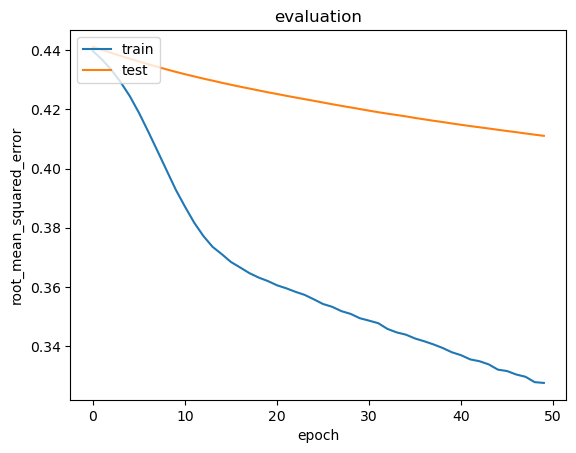

In [468]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('evaluation')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()